In [5]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

In [6]:
#数据预处理 正则表达式提取数字
data_0 = pd.read_excel("微博-关键词内容.xlsx")
for index, row in data_0.iterrows():
    #提取年月日
    d = re.findall(r'\d*年*\d*月\d*日',row["发布时间"])
    d = re.sub(r'年|月|日','-',str(d))
    data_0.at[index,"发布时间"] = d
#对文本数量进行计数
data = data_0["发布时间"].value_counts(sort=False)
del data["['11-04-']"]
data

['06-30-']         959
['10-09-']         171
['11-06-']           1
['11-07-']         721
['11-8-']            5
['2016-06-24-']      9
['2016-06-25-']      3
['2016-06-26-']      5
['2016-06-27-']     57
['2016-06-28-']     70
['2016-06-29-']     86
['2016-06-30-']     50
['2016-12-26-']     15
['2016-12-27-']     15
['2016-12-28-']     12
['2016-12-29-']    192
['2016-12-30-']     70
['2016-12-31-']     16
['2017-06-26-']      8
['2017-06-27-']     23
['2017-06-28-']     56
['2017-06-29-']    177
['2017-06-30-']    104
['2017-12-30-']      5
['2017-12-31-']     87
['2018-06-30-']    729
['2018-09-16-']    399
['2018-12-31-']    403
['2019-06-30-']    753
['2019-07-06-']     10
['2019-08-08-']      1
['2019-11-04-']      1
['2019-12-02-']      1
['2019-12-31-']    697
['2020-06-30-']    871
['2020-12-31-']    709
Name: 发布时间, dtype: int64

数据的格式出现一些bug:在excel中2021年的时间已经加上去了，但是在代码读取中无法显示。这可能会对后续模型的准确度造成影响

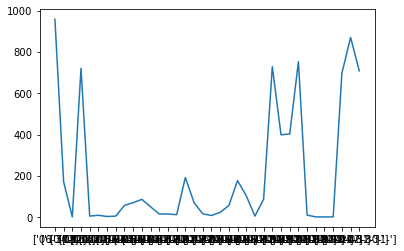

In [7]:
#简单绘制data分布曲线
plt.plot(data)

In [8]:
# 去除数据空值 数据标准化到0~1 
data = data.dropna()
dataset = data.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x:x / scalar,dataset))
dataset

[1.0010438,
 0.17849687,
 0.0010438414,
 0.7526096,
 0.0052192067,
 0.009394572,
 0.003131524,
 0.0052192067,
 0.059498955,
 0.073068894,
 0.089770354,
 0.052192066,
 0.01565762,
 0.01565762,
 0.012526096,
 0.20041753,
 0.073068894,
 0.016701462,
 0.008350731,
 0.02400835,
 0.058455113,
 0.18475991,
 0.1085595,
 0.0052192067,
 0.090814196,
 0.76096034,
 0.4164927,
 0.42066807,
 0.78601253,
 0.010438413,
 0.0010438414,
 0.0010438414,
 0.0010438414,
 0.7275574,
 0.9091858,
 0.7400835]

In [9]:
#我们通过前两个时间点的文本数作为输入 当天的文本数作为输出
def crt_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)
# 创建好输入输出
data_X, data_Y = crt_dataset(dataset)
data_X

array([[1.0010438 , 0.17849687],
       [0.17849687, 0.00104384],
       [0.00104384, 0.7526096 ],
       [0.7526096 , 0.00521921],
       [0.00521921, 0.00939457],
       [0.00939457, 0.00313152],
       [0.00313152, 0.00521921],
       [0.00521921, 0.05949895],
       [0.05949895, 0.07306889],
       [0.07306889, 0.08977035],
       [0.08977035, 0.05219207],
       [0.05219207, 0.01565762],
       [0.01565762, 0.01565762],
       [0.01565762, 0.0125261 ],
       [0.0125261 , 0.20041753],
       [0.20041753, 0.07306889],
       [0.07306889, 0.01670146],
       [0.01670146, 0.00835073],
       [0.00835073, 0.02400835],
       [0.02400835, 0.05845511],
       [0.05845511, 0.18475991],
       [0.18475991, 0.1085595 ],
       [0.1085595 , 0.00521921],
       [0.00521921, 0.0908142 ],
       [0.0908142 , 0.76096034],
       [0.76096034, 0.4164927 ],
       [0.4164927 , 0.42066807],
       [0.42066807, 0.78601253],
       [0.78601253, 0.01043841],
       [0.01043841, 0.00104384],
       [0.

In [10]:
# 划分训练集和测试集，80% 作为训练集
train_size = int(len(data_X) * 0.8)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [11]:
#根据网络结构改变输入输出tensor形状
import torch

train_X = np.array(train_X).reshape(-1, 1, 2)
train_Y = np.array(train_Y).reshape(-1, 1, 1)
test_X = np.array(test_X).reshape(-1, 1, 2)
#转化为tensor
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [12]:
from torch import nn
from torch.autograd import Variable
Loss = []
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归

    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x
    #因为有两个月的特征所以是2 hidden_size可以随便选择
net = lstm_reg(2, 8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

# 开始训练 较为模板化(神经网络基本这个结构)
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    Loss.append(loss.item())
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))


Epoch: 100, Loss: 0.05226
Epoch: 200, Loss: 0.00981
Epoch: 300, Loss: 0.00302
Epoch: 400, Loss: 0.00157
Epoch: 500, Loss: 0.00126
Epoch: 600, Loss: 0.00096
Epoch: 700, Loss: 0.00084
Epoch: 800, Loss: 0.00063
Epoch: 900, Loss: 0.00056
Epoch: 1000, Loss: 0.00050


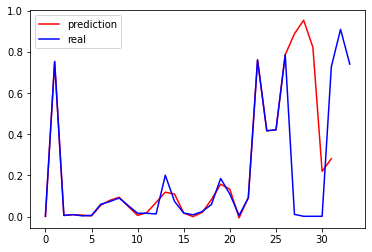

In [19]:
net = net.eval() # 转换成测试模式
data_X = np.array(data_X).reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果
# 改变输出的格式
pred_test = pred_test.view(-1).data.numpy()


plt.plot(pred_test[:], 'r', label='prediction')
plt.plot(dataset[2:], 'b', label='real')
plt.legend(loc='best')

In [18]:
len(dataset)

36

In [ ]:
#迭代误差图
x = range(len(Loss))
plt.plot(x,Loss)

In [ ]:
# 预测误差均值
np.mean(abs(pred_test-dataset[2:]))

In [ ]:
a = '777777677'
a = a.replace('6','7')
a